In [1]:
import argparse
import gym
import random
import copy 
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from drawnow import drawnow
import matplotlib.pyplot as plt

from collections import deque
from torch.distributions import MultivariateNormal,Beta,Normal

#from ride_hailing_env import RideHailingENV

import folium

C:\Users\zhh\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Modified Environment

In [ ]:
"""
# Ride_hailing env
This is the file for defining the simulator for the ride-hailing environment.
Functions defined in this file can be used for reinforcement learning.
This is part of the master thesis project:
Optimising matching radius for a ride-hailing system.

# Use this .py script:
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, done = env.reset()
ob_rider, ob_driver, reward = env.step(action, time_step, rend_step=False)

# Test this environment for one step:
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, ob_distance, done = env.reset()
action = np.full(4, 800)
ob_rider, ob_driver, ob_distance, reward, done = env.step(action, hr_time=1, rend_step=True)
print(reward, done)

# Test this environment for one episode (5 hours):
env = RideHailingENV(grid_div=2)
ob_rider, ob_driver, ob_distance, done = env.reset()
time_step, ep_reward, step_count = 1, 0, 0
action = np.full(4, 800)
while not done:
    ob_rider, ob_driver, ob_distance, reward, done = env.step(action, time_step, rend_step=False)
    ep_reward += reward
    step_count += 1
print(f'{ep_reward} | {step_count}')
"""


import gym
import folium

import numpy as np
import pandas as pd

from gym import spaces
from folium.features import DivIcon
from IPython.display import display
from ride_hailing_match import Match
from ride_hailing_location_model import Build_Model
from pyproj import Transformer


Global_Resolution = 7 # change the resolution here, determines the number of cells
# !!!! change


def wgs84_to_xy(x_arr: np.ndarray, y_arr: np.ndarray):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32614')
    x0 = 604082.94
    y0 = 3328141.76
    x_arr_new, y_arr_new = transformer.transform(x_arr, y_arr)
    x_arr_new -= x0
    y_arr_new -= y0
    return x_arr_new.tolist(), y_arr_new.tolist()

def xy_to_wgs84(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_new = np.array(xy_list[0]) + 604082.94
    y_new = np.array(xy_list[1]) + 3328141.76
    lat_lon = transformer.transform(x_new, y_new)
    return lat_lon

def xy_to_wgs84_list(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_arr = np.array(xy_list[0]) + 604082.94
    y_arr = np.array(xy_list[1]) + 3328141.76
    lat_list, lon_list = transformer.transform(x_arr, y_arr)
    return lat_list.tolist(), lon_list.tolist()


class Cell:
    """Gennerate cells
    """
    def __init__(self, num_divisions) -> None:
        self.lat_range = np.array([30.18, 30.32]) # Austin latitude range
        self.lon_range = np.array([-97.81, -97.65]) # Austin longitude range
        self.x_range, self.y_range = wgs84_to_xy(self.lat_range, self.lon_range)
        self.num_divisions = num_divisions # how many part lat and lon are divided
        pass
   
    def pass_info(self):
        return self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions
    
    def get_cells(self, display_map: bool = False) -> list:
        number =  self.num_divisions ** 2
        cells = np.arange(number)

        if display_map == False:
            return cells
        
        else:
            lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
            lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
            m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)
            for i in range(self.num_divisions):
                for j in range(self.num_divisions):
                    lat_start = self.lat_range[0] + i * lat_step
                    lat_end = lat_start + lat_step
                    lon_start = self.lon_range[0] + j * lon_step
                    lon_end = lon_start + lon_step
                    grid_number = i * self.num_divisions + j

                    # Draw the grid
                    folium.Rectangle(
                        bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                        color='blue',
                        fill=True,
                        fill_opacity=0.1
                    ).add_to(m)

                    # Add grid number
                    folium.Marker(
                        location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                        icon=folium.DivIcon(html=f'<div style="font-size: 12pt">{grid_number}</div>')
                    ).add_to(m)

            # draw action range
            folium.Circle(
                radius=50,
                location=[(self.lat_range[1]-self.lat_range[0])/2+self.lat_range[0], (self.lon_range[1]-self.lon_range[0])/2+self.lon_range[0]],
                color="red",
                weight=5,
                fill=False,
            ).add_to(m)
            folium.Circle(
                radius=3000,
                location=[(self.lat_range[1]-self.lat_range[0])/2+self.lat_range[0], (self.lon_range[1]-self.lon_range[0])/2+self.lon_range[0]],
                color="red",
                weight=5,
                fill=False,
            ).add_to(m)

            display(m)
            return cells

    def get_cell_id_wgs84(self, lat, lon):
        if not (self.lat_range[0] <= lat <= self.lat_range[1]) or not (self.lon_range[0] <= lon <= self.lon_range[1]): # check if in the range
            return None
        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        lat_index = min(int((lat - self.lat_range[0]) / lat_step), self.num_divisions - 1)
        lon_index = min(int((lon - self.lon_range[0]) / lon_step), self.num_divisions - 1)
        grid_number = lat_index * self.num_divisions + lon_index
        return grid_number
    
    def get_cell_id_xy(self, x_list, y_list):
        cell_ids = []
        x_step = (self.x_range[1] - self.x_range[0]) / self.num_divisions
        y_step = (self.y_range[1] - self.y_range[0]) / self.num_divisions

        for x, y in zip(x_list, y_list):
            x_index = min(int((x - self.x_range[0]) / x_step), self.num_divisions - 1)
            y_index = min(int((y - self.y_range[0]) / y_step), self.num_divisions - 1)
            grid_number = x_index + y_index * self.num_divisions
            cell_ids.append(grid_number)
        
        return cell_ids
        

class Gen_Model:
    """Sample locations from fitted model for riders and drivers in the map

    This class is to generate locations for riders and drivers based on the given
    distribution of their locations. This default model is estimated with Kernel 
    Density Estimation (KDE). The generated location is given in the format of 
    a pandas DataFrame, each row represents a unique rider/driver. Information
    given in a row includes rider/driver's ID, H3 code, longitude and latitude.

    Attributes:
        model: an instance of Build_Model class containing models for riders and drivers
        rider_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of riders
        driver_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of drivers
    """
    def __init__(self, num_div) -> None:
        self.cell = Cell(num_div)
        self.cell_ids = self.cell.get_cells(False)
        self.model = Build_Model()
        self.rider_model, self.driver_model = self.model.get_model()

    def gen_drivers(self, number_of_drivers: int, hr_time: int, seed: int = None):
        """Sample locations for drivers
        
        Sample multiple locations for drivers based on the given locational distribution 
        of drivers. The default distribution model is KDE.

        Parameters:
            number_of_drivers: an int, indicating how many drivers are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            driver_df: a pandas DataFrame, including information of generated drivers. 
        """
        if seed != None:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers, seed) # dtype = numpy ndarray
        else:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers) # dtype = numpy ndarray
        driver_ids = []
        cell_ids = []

        for driver_id, geo_info in enumerate(driver_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                driver_locations[driver_id] = geo_info
                #print('Re-sampled a driver!')
            cell_ids.append(cell_id)
            driver_ids.append(driver_id)

        x_list, y_list = wgs84_to_xy(driver_locations.T[0], driver_locations.T[1])

        driver_df = pd.DataFrame({'driver_id':driver_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'statue': 1, 'idle_time': 0})
        # driver is avliable: 'statue' = 1, unavliable: 'statue' = 0
        # driver_df[['driver_id', 'cell_id']] = driver_df[['driver_id', 'cell_id']].astype(int) # set data type to int

        return driver_df

    def gen_riders(self, number_of_riders: int, hr_time: int, seed: int = None):
        """Sample locations for riders
        
        Sample multiple locations for riders based on the given locational distribution 
        of riders. The default distribution model is KDE.

        Parameters:
            number_of_riders: an int, indicating how many riders are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            rider_df: a pandas DataFrame, including information of generated riders. 
        """
        if seed != None:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders, seed) # dtype = numpy ndarray
        else:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders) # dtype = numpy ndarray
        rider_ids = []
        cell_ids = []
        
        for rider_id, geo_info in enumerate(rider_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                rider_locations[rider_id] = geo_info
                #print('Re-sampled a rider!')
            cell_ids.append(cell_id)
            rider_ids.append(rider_id)

        x_list, y_list = wgs84_to_xy(rider_locations.T[0], rider_locations.T[1])

        rider_df = pd.DataFrame({'rider_id':rider_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'time_step_in_pool': 1})
        # rider_df[['rider_id', 'cell_id', 'time_step_in_pool']] = rider_df[['rider_id', 'cell_id', 'time_step_in_pool']].astype(int) # set data type to int

        return rider_df



In [159]:

class RideHailingENV(gym.Env):
    """Simulation environment for project optimising matching radius for ride-hailing system

    This class is the main simulator for the master thesis project optimising matching radius 
    for a ride-hailing system with reinforcement learning. The project is carried out in TU Delft. 
    This simulator is built base on the geographical information of Austin, Texas, USA. It intake
    continous matching radius as the action, and the reward is the total net profit made by the 
    system within a day.

    GOOD action for example:
    action = np.ones(36)*800
    action[[5, 13, 14, 15, 19, 20, 21, 26, 27]] = 400

    Attributes:
     lower_bound - lower bound of action space, minimum matching radius, unit is meters.
     upper_bound - upper bound of action space, maximum matching radius, unit is meters.
     model - make an instance of Gen_Model class, to generate riders and drivers for the simulator.
     match - make an instance of Match class, to run the matching algorithm.
     radius_initial - initial matching radius when reset the environment, unit is meters.
     driver_num_ini - initial number of drivers, can be changed if set dynamic.
     rider_num_ini - initial number of riders, rider number is changing among different steps.
     fuel_unit_price - average travelling fuel cost per vehicle per kilometer in the US, the unit is US dollars.
     time_window - time interval between every two matching process (Uber Batched matching), fixed among all steps, unit is minutes.
     total_reward - total reward for the intake action.
     gen_rate_rider - overall generating rate of riders, number of riders per time-window.
     gen_rate_driver - active if vehicle number are set dynamic, number of new drivers per time-window.
     ride_price - average ride price in Austin urban area, the value is estimated from Uber ride data in 2022.
     rider_patience - the maximum number of steps a rider can stay in the matching pool.
     p_unmatch_rider - penalty per unmatched rider, the value is cauculated base on the probability of losing a potential ride.
     action_space - defines the numerical range of intake actions.
     observation_space - defines the numerical range of overall observations.
     sub_observation_space - defines the numerical range of observations within a cell.

    Distance cost explain:
     distance cost = car-buying cost + car repair and maintanance cost + fuel cost
     car repair and maintanance cost = change tire per 200000km &1000 + change motor oil per 200000km $1200
     car-buying cost: average car price in the us is $22000
     fuel cost: averge fuel cost $1.3/L * averge fuel comsuption 9.3L/100km = $12.1/100km = $0.12/km
     total = $11.65/km
    """
    def __init__(self, grid_div, time_window: int = 0.25) -> None:

        self.lower_bound = 50
        self.upper_bound = 3000
        self.num_divi = grid_div
        self.cell = Cell(self.num_divi)
        self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions = self.cell.pass_info()
        self.model = Gen_Model(self.num_divi)
        self.match = Match()
        self.seed_ini = None

        self.cell_ids = self.cell.get_cells(False)
        self.cell_num = np.size(self.cell_ids)
        self.radius_initial = 500
        self.driver_num_ini = 100
        self.rider_num_ini = 15
        self.distance_cost = 13.26 * 0.001 # this is a combination of fuel cost, car-buying and car-repair cost, unit is per meter
        self.fuel_cost = 1.93 * 0.001
        self.time_window = time_window
        self.total_reward = 0
        self.gen_rate_rider = 10
        self.gen_rate_driver = 10
        self.ride_price = 23.92
        self.rider_patience = 5 # minutes
        self.p_rider_left = 0.1 # punishment
        self.p_unmatch_rider = 5
        self.simulation_time = 30

        self.drivers = None
        self.riders = None
        self.drivers_tmp = None
        self.riders_tmp = None

        self.score_distance = lambda distance, max_distance=2000: max(0, min(1, 1 - distance / max_distance))
        self.score_radius = lambda distance, max_distance=8000: max(0, min(1, 1 - distance / max_distance))
        self.score_radius_neg = lambda distance, max_distance=8000: max(0, min(1, distance / max_distance))
        self.score_diff = lambda distance, max_distance=1500: max(0, min(1, 1 - distance / max_distance))
        self.score_rate = lambda rate: 1 if rate > 0.9 else (0 if rate < 0.5 else (rate - 0.5) / 0.4)
        self.multi_task_weight_factor = [0.6, 0.4, 0.1] # order fulfillment rate, average pickup distance, driver utilization rate
        self.rate_goal, self.radius_goal = 0.85, 0.5
        #self.multi_task_weight = [0.6, 0.4] # order fulfillment rate, average pickup distance

        self. rider_patience_step = self.rider_patience / self.time_window

        self.action_dim = self.cell_num
        self.observation_dim = 2*self.cell_num + 2
        self.step_count = 0
        self.max_step = self.simulation_time / self.time_window

    def reset(self, time_ini: int = 18) -> np.array:
        """
        reset the environment for the first step in every episode.

        Parameters:
         time_ini -  set the initial time to 0-1 hour of a day.

        Returns:
         returns the initial matching radius.
        """
        self.random_seed = self.seed_ini
        self.drivers = self.model.gen_drivers(self.driver_num_ini, time_ini, self.random_seed)
        self.drivers_in_service = np.zeros(self.driver_num_ini, dtype=np.int32)
        self.drivers['driver_id'] = np.arange(self.drivers.shape[0])

        self.riders = self.model.gen_riders(self.rider_num_ini, time_ini, self.random_seed)
        self.riders['rider_id'] = np.arange(self.riders.shape[0])

        self.observe = np.zeros([self.num_divi ** 2, 2]) # reset observation space

        done = False
        self.step_count = 0

        ratio, avg_dis = self.get_observe()
        self.matched_ride_num = 0
        self.ride_demand_num = self.rider_num_ini
        self.avg_distance_pf = 0
        self.driver_ult = 0
        self.radius_base = avg_dis # base radius for action to learn
        self.action_ini = np.ones(self.cell_num) * 50
        self.on_goal = 0
        diff = self.rate_goal

        state = np.concatenate((ratio, avg_dis, [diff], [1. if self.on_goal else 0.]))

        return state #, self.riders, self.drivers
    
    def step(self, radius: np.array, hr_time: int = 18, rend_step: bool = False) -> tuple[float, dict, list]:
        """
        The main process of a step.

        Parameters:
         action - the current macthing radius
         observe 1 - the current matching radius
         observe 2 - the difference between current and goal

        Returns:
         the reward and done statue
        """

        #print(self.x_range, self.y_range, self.drivers)
        #self.random_seed += 1 # update seed
        self.action_ini = radius
        self.riders_tmp = self.riders.copy()
        self.drivers_tmp = self.drivers.copy()

        # get the distance matrix and matching pool
        cell_ids = self.riders['cell_id']
        r_radius = radius[cell_ids]

        # get the matching pool
        pool = self.__get_pool(self.dis_matrix, r_radius)

        # matching process
        reward = 0
        match_statue = self.__match(pool)
        #reward_ = self.__execute_match(match_statue, pool, radius)
        rate = len(match_statue)/len(self.riders)
        reward -= sum(radius)/self.cell_num/3000 # noramalize to [0, 1]
        if rate >= self.rate_goal:
            self.on_goal += 1
            reward += 0.025 * self.on_goal
            if self.on_goal > 40:
                reward += 1
                done = True
            else:
                done = False
        else:
            self.on_goal = 0
            done = False

        diff = 0. if self.on_goal else self.rate_goal - rate

        if rend_step:
            state = [self.riders_tmp, self.drivers_tmp]
            self.render(state, radius, match_statue)

        ratio, avg_dis = self.get_observe()
        avg_dis = avg_dis / 3000
        ratio = ratio / 10

        state = np.concatenate((ratio, avg_dis, [diff], [1. if self.on_goal else 0.]))

        return state, reward, done
    
    def get_observe(self): # observation is number of riders/drivers in each cell

        # new version observation, according to ref: cell num, time_step, previoud radius, number of drivers, number of riders
        rider_counts = self.riders['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()
        supply_driver = self.drivers[self.drivers['statue']==1]
        driver_counts = supply_driver['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()

        avg_distance = np.full(self.cell_num, 0)  # Initialize with 6000 for cells with no riders

        rider_vec = self.riders[['x', 'y']].values
        driver_vec = self.drivers[['x', 'y']].values

        # get the distance matrix and matching pool
        self.dis_matrix = self.__vector_dis(rider_vec, driver_vec)
        ratio = np.zeros(self.cell_num)

        # Calculate the minimum distance from each rider to any driver
        for cell_id in range(self.cell_num):
            riders_in_cell = self.riders[self.riders['cell_id'] == cell_id].index
            if len(riders_in_cell) > 0:
                distances = self.dis_matrix[riders_in_cell].min(axis=1)
                distance = distances.mean()
                avg_distance[cell_id] = distance
        
        self.avg_distance = np.clip(avg_distance, 0, 3000)
        #self.diff = abs(self.action_ini - self.radius_base)

        non_zero_indices = rider_counts != 0 
        ratio[non_zero_indices] = driver_counts[non_zero_indices] / rider_counts[non_zero_indices] 

        return ratio, self.avg_distance, #self.diff
    
    def check_done(self):
        if self.step_count >= self.max_step -1: #or self.riders.shape[0] == 0:
            done = True
        else:
            done = False
        return done

    def __get_pool(self, dis_matrix: np.matrix, radius_set: int) -> np.ndarray:
        """
        form a matching pool for all the riders and available drivers whithin the matching radius.

        Parameters:
            riders - locations, numbers of all the riders.
            drivers - locations, numbers of all the drivers.
            radius - matching radius for each cell, riders in the same cell have the same matching radius.

        Returns:
            returns a list consist all the possible matches and the distance between them.
        """
        match_pool = []
        for i in range(dis_matrix.shape[0]):
            sub_pool = []
            radius_rider = radius_set[i]
            driver_1 = np.where(dis_matrix[i] <= radius_rider)[1]
            driver_2 = self.drivers.index[self.drivers['statue'] == 1]
            driver = list(np.intersect1d(driver_1, driver_2))
            rider = list(np.ones(np.size(driver), dtype=int)*i)
            dis = dis_matrix[i, driver].tolist()[0]
            sub_pool.extend([rider])
            sub_pool.extend([driver])
            sub_pool.extend([dis])
            sub_pool = list(map(list, zip(*sub_pool)))
            match_pool.extend(sub_pool)
        return match_pool
            
    def __match(self, pool: list): # MM: Maximum Matching, OM: Optimised Matching
        """
        excute matching algorithm to find the optimal match for the given matching pool.

        Parameters:
         pool - matching pool with distance. 

        Returns:
         match statue with matched pairs and their distance. 
        """
        matched_pairs = self.match.match(pool, method='Munkres')
        return matched_pairs
    
    def __execute_match(self, match_statue:list, match_pool: list, radius: np.array) -> tuple[float, tuple]:
        """
        apply the matched pairs to the map, update riders and drivers, observe reward and penalty.

        Parameters:
        riders - locations, numbers of all the riders.
        drivers - locations, numbers of all the drivers.
        match_statue - matched pair of riders and drivers with the distance between them.

        Returns:
        reward - the net monetary profit made from the ride-hailing system within a step.
        pool_next - next state of the environment after taking the action.
        """
        # calculate total distance and rewards
        reward = 0 #- 200 * self.distance_cost
        #complete_rate = self.score_rate(len(match_statue) / len(self.riders))
        self.matched_ride_num += len(match_statue)
        #self.driver_ult += len(match_statue) / len(self.drivers[self.drivers['statue']==1])
        
        if match_statue:
            #aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            riders_to_drop, drivers_to_drop = zip(*[(rider, driver) for rider, driver, _ in match_statue])
            riders_to_drop, drivers_to_drop = list(riders_to_drop), list(drivers_to_drop)
            #reward_match_rate = len(match_statue) / len(self.riders)
            #reward_driver_ult = len(match_statue) / len(match_pool)
        else:
            #aver_distance = 0 # in case for tricky policies
            riders_to_drop, drivers_to_drop = [], []
            #reward_match_rate = 0
            #reward_driver_ult = 0
        """         
        reward_distance = self.score_distance(aver_distance)
        self.avg_distance_pf += aver_distance
        #print(complete_rate, reward_distance, reward_driver_ult)
        #reward_diff = abs(radius - self.avg_distance)
        #base_radius_diff = sum(self.diff)

        reward = complete_rate * self.multi_task_weight_factor[0] + reward_distance * self.multi_task_weight_factor[1] + reward_driver_ult * self.multi_task_weight_factor[2]
        #reward = complete_rate * self.multi_task_weight_factor[0] + self.score_diff(sum(reward_diff)/self.cell_num) * self.multi_task_weight_factor[1]
        #reward = self.score_diff(sum(reward_diff)/self.cell_num) * self.multi_task_weight_factor[1]
        #reward = complete_rate * self.multi_task_weight_factor[0] - self.score_radius_neg(sum(radius)) * self.multi_task_weight_factor[1]
        #reward = complete_rate * self.multi_task_weight_factor[0] + self.score_radius(sum(radius)) * self.multi_task_weight_factor[1]
        #reward = complete_rate * self.multi_task_weight_factor[0] + self.score_diff(sum(base_radius_diff)) * self.multi_task_weight_factor[1]"""

        self.riders = self.riders.drop(riders_to_drop)
        self.drivers_in_service[drivers_to_drop] += 2
        self.drivers.loc[drivers_to_drop, 'statue'] = 0
        self.drivers.loc[drivers_to_drop, 'idle_time'] = 0

        self.riders['time_step_in_pool'] += 1
        self.riders = self.riders.drop(self.riders[self.riders['time_step_in_pool']>self.rider_patience_step].index) # inpatient riders quit the matching pool

        # calculate net reward
        net_reward = reward

        return net_reward
    
    def __vector_dis(self, rider_vec, driver_vec):
        m = np.shape(rider_vec)[0]
        n = np.shape(driver_vec)[0]
        M = np.dot(rider_vec, driver_vec.T)
        H = np.tile(np.matrix(np.square(rider_vec).sum(axis=1)).T,(1,n))
        K = np.tile(np.matrix(np.square(driver_vec).sum(axis=1)),(m,1))
        return np.sqrt(-2 * M + H + K)
    
    def __state_transit(self, hr_time: int, reward: float, match_statue: list) -> dict: 
        """
        update the current state and give the state of the next step.
        v1_update: do not gennerate new riders, terminal is all the riders are matched or left

        Parameters:
         state - the current state, locations of riders and drivers.
         hr_time - hourly time of a day, this is used to generate new riders and drivers.

        Returns:
         returns the locations of riders and drivers for the next step.
        """
        ride_num = np.size(match_statue)

        # update riders
        done = self.check_done()
        if done == True:
            self.riders = self.riders.reset_index(drop=True)
            self.drivers = self.drivers.reset_index(drop=True)
            # re-index drivers and riders
            driver_index = self.drivers.shape[0]
            self.drivers['driver_id'] = np.arange(driver_index)
            rider_index = self.riders.shape[0]
            self.riders['rider_id'] = np.arange(rider_index)

            return self.riders, self.drivers, reward, done

        rider_size = self.gen_rate_rider
        self.ride_demand_num += rider_size
        new_riders = self.model.gen_riders(rider_size, hr_time, self.random_seed)
        rider_next = pd.concat((self.riders, new_riders), axis=0)

        self.drivers.loc[self.drivers_in_service == 0, 'statue'] = 1 # drivers finished ride

        # update drivers - driver reposition
        self.drivers.loc[self.drivers['statue'] == 1, 'idle_time'] += 1 # update idle time
        condition = (self.drivers['idle_time'] == 20) & (self.drivers['statue'] == 1)
        self.drivers.loc[condition, 'x'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'y'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'idle_time'] = 0 # reset idle time

        # update drivers - driver idling
        self.drivers_in_service[self.drivers_in_service != 0] -= 1
        self.drivers['x'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])
        self.drivers['y'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])

        # check latitude and longitude border
        self.drivers['x'] = np.clip(self.drivers['x'], self.x_range[0], self.x_range[1]) # check latitude range
        self.drivers['y'] = np.clip(self.drivers['y'], self.y_range[0], self.y_range[1]) # check longitude range

        # update cell ids for drivers
        self.drivers['cell_id'] = self.cell.get_cell_id_xy(self.drivers['x'], self.drivers['y']) 

        #rider_next = rider_next.reset_index(drop=True)
        self.riders = rider_next.reset_index(drop=True)
        self.drivers = self.drivers.reset_index(drop=True)

        # re-index drivers and riders
        driver_index = self.drivers.shape[0]
        self.drivers['driver_id'] = np.arange(driver_index)
        rider_index = self.riders.shape[0]
        self.riders['rider_id'] = np.arange(rider_index)

        return self.riders, self.drivers, reward, done
    
    def get_performance_statue(self):
        match_rate = self.matched_ride_num / (self.ride_demand_num - self.gen_rate_rider)
        avg_pick_distance = self.avg_distance_pf / self.step_count
        driver_ult = self.driver_ult / self.step_count
        return match_rate, avg_pick_distance, driver_ult

    def render(self, state: tuple, radius_set: dict, match_statue: list, color_set: tuple = ['red', 'blue'], folium_map=None) -> None:
        """
        visualise the state and action for one step, red circle is matching range (within matching radius),
        green lines are the links for matched pairs.

        Parameters:
         state - the current state, locations of riders and drivers.
         radius_set - matching radius for each cell.
         match_statue - matched pair of riders and drivers with the distance between them.
         folium_map - map object.
        """

        riders = state[0]
        drivers = state[1]
        drivers = drivers[drivers['statue'] == 1]
        drivers.reset_index(drop=True, inplace=True)
        matched_riders = []
        matched_drivers = []
        if match_statue != []:
            matched_riders = pd.DataFrame(match_statue)[0].to_list()
            matched_drivers = pd.DataFrame(match_statue)[1].to_list()

        matched_rider_location = {}
        matched_driver_location = {}

        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)
        for i in range(self.num_divisions):
            for j in range(self.num_divisions):
                lat_start = self.lat_range[0] + i * lat_step
                lat_end = lat_start + lat_step
                lon_start = self.lon_range[0] + j * lon_step
                lon_end = lon_start + lon_step
                grid_number = i * self.num_divisions + j
                # Draw the grid
                folium.Rectangle(
                    bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                    color='blue',
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
                # Add grid number
                folium.Marker(
                    location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                    icon=folium.DivIcon(html=f'<div style="font-size: 18pt">{grid_number}</div>')
                ).add_to(m)
       
        # add driver markers
        for i in range(drivers.shape[0]):
            driver_wgs = xy_to_wgs84([drivers.loc[i]['x'], drivers.loc[i]['y']])
            folium.Marker(
                location=driver_wgs,
                icon=folium.Icon(
                    color=color_set[0],
                    prefix='fa',
                    icon='car'
                    )
                ).add_to(m)
            if drivers.loc[i]['driver_id'] in matched_drivers:
                matched_driver_location[f'{int(drivers.loc[i]["driver_id"])}'] = driver_wgs
          
        # add rider markers and matching radius
        for j in range(riders.shape[0]):
            rider_wgs = xy_to_wgs84([riders.loc[j]['x'], riders.loc[j]['y']])
            folium.Marker(
                location=rider_wgs,
                icon=folium.Icon(
                    color=color_set[1],
                    prefix='fa',
                    icon='male'
                    )
                ).add_to(m)
            
            folium.Circle(
                    radius=float(radius_set[int(riders.loc[j]['cell_id'])]),
                    location=rider_wgs,
                    color="red",
                    weight=1,
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
            if riders.loc[j]['rider_id'] in matched_riders:
                matched_rider_location[f'{int(riders.loc[j]["rider_id"])}'] = rider_wgs
       
        for rider, driver, dis in match_statue:
            folium.PolyLine(
                locations=[matched_rider_location[f'{int(rider)}'], matched_driver_location[f'{int(driver)}']],
                color='green', 
                weight=5,
                tooltip='matched_links'
                ).add_to(m)
    
        display(m)
        pass

In [160]:
class ArmEnv(object):
    viewer = None
    dt = .1    # refresh rate
    action_bound = [-1, 1]
    goal = {'x': 100., 'y': 100., 'l': 40}
    state_dim = 9
    action_dim = 2

    def __init__(self):
        self.arm_info = np.zeros(
            2, dtype=[('l', np.float32), ('r', np.float32)])
        self.arm_info['l'] = 100        # 2 arms length
        self.arm_info['r'] = np.pi/6    # 2 angles information
        self.on_goal = 0

    def step(self, action):
        done = False
        action = np.clip(action, *self.action_bound)
        self.arm_info['r'] += action * self.dt
        self.arm_info['r'] %= np.pi * 2    # normalize

        (a1l, a2l) = self.arm_info['l']  # radius, arm length
        (a1r, a2r) = self.arm_info['r']  # radian, angle
        a1xy = np.array([200., 200.])    # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy  # a1 end and a2 start (x1, y1)
        finger = np.array([np.cos(a1r + a2r), np.sin(a1r + a2r)]) * a2l + a1xy_  # a2 end (x2, y2)
        # normalize features
        dist1 = [(self.goal['x'] - a1xy_[0]) / 400, (self.goal['y'] - a1xy_[1]) / 400]
        dist2 = [(self.goal['x'] - finger[0]) / 400, (self.goal['y'] - finger[1]) / 400]
        r = -np.sqrt(dist2[0]**2+dist2[1]**2)

        # done and reward
        if self.goal['x'] - self.goal['l']/2 < finger[0] < self.goal['x'] + self.goal['l']/2:
            if self.goal['y'] - self.goal['l']/2 < finger[1] < self.goal['y'] + self.goal['l']/2:
                r += 1.
                self.on_goal += 1
                if self.on_goal > 50:
                    done = True
        else:
            self.on_goal = 0

        # state
        s = np.concatenate((a1xy_/200, finger/200, dist1 + dist2, [1. if self.on_goal else 0.]))
        #print(finger)
        return s, r, done

    def reset(self):
        self.goal['x'] = np.random.rand()*400.
        self.goal['y'] = np.random.rand()*400.
        print(self.goal)
        self.arm_info['r'] = 2 * np.pi * np.random.rand(2)
        self.on_goal = 0
        (a1l, a2l) = self.arm_info['l']  # radius, arm length
        (a1r, a2r) = self.arm_info['r']  # radian, angle
        a1xy = np.array([200., 200.])  # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy  # a1 end and a2 start (x1, y1)
        finger = np.array([np.cos(a1r + a2r), np.sin(a1r + a2r)]) * a2l + a1xy_  # a2 end (x2, y2)
        # normalize features
        dist1 = [(self.goal['x'] - a1xy_[0])/400, (self.goal['y'] - a1xy_[1])/400]
        dist2 = [(self.goal['x'] - finger[0])/400, (self.goal['y'] - finger[1])/400]
        # state
        s = np.concatenate((a1xy_/200, finger/200, dist1 + dist2, [1. if self.on_goal else 0.]))
        #print(finger)
        return s

    def sample_action(self):
        return np.random.rand(2)-0.5    # two radians

In [161]:
class Memory(object):
  def __init__(self, memory_size=30000):
    self.memory = deque(maxlen=memory_size)
    self.memory_size = memory_size

  def __len__(self):
    return len(self.memory)

  def append(self, item):
    self.memory.append(item)

  def sample_batch(self, batch_size):
    idx = np.random.permutation(len(self.memory))[:batch_size]
    return [self.memory[i] for i in idx]
  
  def get_memory(self):
    return self.memory

# Simple Ornstein-Uhlenbeck Noise generator
class OUNoise(object):
  """ Ornstein-Uhlenbeck process noise """
  def __init__(self, size, mu=0.0, theta=0.15, sigma=0.3):
        """ Initialize parameters and noise process """
        self.mu = mu * np.ones(size)
        self.theta = theta 
        self.sigma = sigma
        self.size = size
        self.reset()

  def reset(self):
        """ Reset the interal state (= noise) to mean (mu). """
        self.state = copy.copy(self.mu)

  def sample(self):
        """ Update internal state and return it as a noise sample """
        self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.standard_normal(self.size)
        return self.state
  

class Actor(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(Actor, self).__init__()
    self.fc_rider = nn.Linear(state_dim, 128)
    self.fc_1 = nn.Linear(128, 256)
    self.fc_2 = nn.Linear(256, 128)
    self.fc_out = nn.Linear(128, action_dim, bias=True) # was False

    init.xavier_normal_(self.fc_rider.weight)
    init.xavier_normal_(self.fc_1.weight)
    init.xavier_normal_(self.fc_2.weight)
    init.xavier_normal_(self.fc_out.weight)

  def forward(self, rider_ob):
    out_r = F.elu(self.fc_rider(rider_ob))
    out = F.elu(self.fc_1(out_r))
    out = F.elu(self.fc_2(out))
    out = F.tanh(self.fc_out(out))
    return out


class Critic(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    self.fc_rider = nn.Linear(state_dim, 100)
    self.fc_action = nn.Linear(action_dim, 100)
    self.fc_1 = nn.Linear(200, 200)
    self.fc_2 = nn.Linear(200, 100)
    self.fc_value = nn.Linear(100, 1, bias=True) # was False

    init.xavier_normal_(self.fc_rider.weight)
    init.xavier_normal_(self.fc_action.weight)
    init.xavier_normal_(self.fc_1.weight)
    init.xavier_normal_(self.fc_2.weight)
    init.xavier_normal_(self.fc_value.weight)

  def forward(self, rider_ob, action):
    out_r = F.elu(self.fc_rider(rider_ob))
    out_a = F.elu(self.fc_action(action))
    out = torch.cat([out_r, out_a], dim=1)
    out = F.elu(self.fc_1(out))
    out = F.elu(self.fc_2(out))
    out = self.fc_value(out)
    return out


class DDPG:
  """
  Norm params
    iter 1: rider:  mean = 0.30813, std = 0.99681 | driver:  mean = 2.49566, std = 3.66580
    iter 2: rider:  mean = 0.90319, std = 2.39189 | driver:  mean = 2.53821, std = 3.70436
    iter 3: rider:  mean = 22.1580, std = 19.3104 | driver:  mean = 19.4841, std = 12.1474
    iter 4: rider:  mean = 15.4974, std = 16.4297 | driver:  mean = 10.3216, std = 10.2087

  """
  def __init__(self, args) -> None:
    self.args = args
    #self.env = RideHailingENV(grid_div=4)
    self.env = RideHailingENV(grid_div=self.args.num_divi)
    self.action_dim = self.env.action_dim
    self.state_dim = self.env.observation_dim

    self.actor = Actor(self.state_dim, self.action_dim)
    self.critic = Critic(self.state_dim, self.action_dim)
    self.actor_target = Actor(self.state_dim, self.action_dim)
    self.critic_target = Critic(self.state_dim, self.action_dim)
    self.actor_target.load_state_dict(self.actor.state_dict()) # initial target net weights from policy net
    self.critic_target.load_state_dict(self.critic.state_dict()) # initial target net weights from value net
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.args.lr_actor)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.args.lr_critic)
    
    self.max_action = self.env.upper_bound
    self.min_action = self.env.lower_bound
    self.axis = (self.min_action + self.max_action) / 2
    self.scale = (self.max_action - self.min_action) / 2
    self.noise = OUNoise(self.action_dim, theta=0.1, sigma=0.5) # import noise # smaller noise

    self.last_score_plot = []
    self.avg_score_plot = [0]

    self.memory_main = Memory(memory_size=30000)
    self.memory_good_act = Memory(memory_size=30000)

    self.loss_check = []
    self.rider_num = []
    self.max_score = 0

    # Z-score Normalization params
    self.norm_mean_rider, self.norm_std_rider = 0, 1#3.7196875, 6.288498421908346 #46.2662, 31.300931 #0.90319, 2.391894 / 3.7196875, 6.288498421908346, 5.2646625, 7.116209753871351
    self.norm_mean_driver, self.norm_std_driver = 0, 1#5.2646625, 7.116209753871351 #24.9914, 15.329205 #2.538216, 3.704363
    pass

  def get_action(self, actor_net, state_rider):
    if not isinstance(state_rider, torch.Tensor):
      state_rider = torch.from_numpy(state_rider.reshape(1, -1)).float()
    action = actor_net(state_rider)[0]
    return action
  
  def get_action_batch(self, actor_net, state_rider_batch):
    #print(state_rider_batch, state_driver_batch)
    if not isinstance(state_rider_batch, torch.Tensor):
      state_rider_batch = torch.from_numpy(state_rider_batch).float()
    action = actor_net(state_rider_batch)
    return action             
  
  def get_radius(self, action): # re-scale action, method: min-max
    radius = action * self.scale + self.axis
    return radius

  def get_q_value(self, critic_net, state_rider_batch, action):
    if not isinstance(state_rider_batch, torch.Tensor):
      state_rider_batch = torch.from_numpy(state_rider_batch).float()
    if not isinstance(action, torch.Tensor):
      action = torch.from_numpy(action).float()
    q_value = critic_net(state_rider_batch, action)
    return q_value

  def update_actor(self, state_rider_batch):
    action = self.actor(state_rider_batch)
    q_value = -torch.mean(self.critic(state_rider_batch, action)) 
    self.actor_optimizer.zero_grad() # calculate the gradient to update actor
    q_value.backward()
    self.actor_optimizer.step()
    pass

  def update_critic(self, state_rider_batch, action, target):
    q_value = self.critic(state_rider_batch, action)
    loss = F.mse_loss(q_value, target) # minimize loss to update critic
    self.critic_optimizer.zero_grad()
    loss.backward()
    self.critic_optimizer.step()
    check = loss.detach().numpy()
    self.loss_check.append(check)
    pass

  def soft_update(self, target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau) # weights target and source

  def draw_fig(self):
    plt.plot(self.last_score_plot, '-')
    #plt.plot(self.avg_score_plot, 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reinforcement Learning Process')
    plt.grid(True)
    plt.show()

  def run_ddpg(self):
    state_rider = self.env.reset()
    # Z-score Normalization
    #state_rider = (state_rider - self.norm_mean_rider) / self.norm_std_rider
    #state_driver = (state_driver - self.norm_mean_driver) / self.norm_std_driver

    iteration_now = 0
    iteration = 0
    episode = 0
    episode_score = 0
    episode_steps = 0

    memory_warmup = self.args.batch_size * 5

    self.noise.reset()

    while episode < self.args.max_episode:
      print('\rIteration {} | Episode {} | Result -> '.format(iteration_now, episode), end='')
      action = self.get_action(self.actor, state_rider).detach().numpy()

      # blend determinstic action with random action during exploration, noise will become samller during the process
      if episode < self.args.max_explore_eps:
        p = episode / self.args.max_explore_eps
        action = action * p + (1 - p) * self.noise.sample()

      action = np.clip(action, -1, 1) # select valid action range
      radius = self.get_radius(action)
      next_state_rider, reward, done = self.env.step(radius)

      # Z-score Normalization
      #next_state_rider = (next_state_rider - self.norm_mean_rider) / self.norm_std_rider
      #next_state_driver = (next_state_driver - self.norm_mean_driver) / self.norm_std_driver

      #reward = reward # re-sacle the reward for plot
      self.memory_main.append([state_rider, action, reward, next_state_rider, done])
      if reward >= 0.5: # good action threshold > 50
        self.memory_good_act.append([state_rider, action, reward, next_state_rider, done]) # memory for good actions


      if iteration >= memory_warmup:
        memory_batch_0 = self.memory_main.sample_batch(int(self.args.batch_size * 0.5))
        memory_batch_1 = self.memory_good_act.sample_batch(int(self.args.batch_size * 0.5))
        memory_batch = memory_batch_0 + memory_batch_1

        state_rider_batch, action_batch, reward_batch, \
        next_state_rider_batch, done_batch = map(lambda x: torch.tensor(x).float(), zip(*memory_batch))

        action_next = self.get_action_batch(self.actor_target, next_state_rider_batch)

        # using discounted reward as target q-value to update critic
        Q_next = self.get_q_value(self.critic_target, next_state_rider_batch, action_next).detach() # !
        Q_target_batch = reward_batch[:, None] + self.args.gamma * (1 - done_batch[:, None]) * Q_next # !
        self.update_critic(state_rider_batch, action_batch, Q_target_batch) # !
        self.update_actor(state_rider_batch) # !

        # soft update
        self.soft_update(self.actor_target, self.actor, self.args.tau)
        self.soft_update(self.critic_target, self.critic, self.args.tau)

      episode_score += reward
      episode_steps += 1
      iteration_now += 1
      iteration += 1

      if done or episode_steps==200:
        episode_score -= 0#50 # re-scale to plot
        print('Episode {:03d} | Episode Score:{:.03f} | steps {}'.format(episode, episode_score, episode_steps))
        #print(f'Policy now: {radius}')
        self.avg_score_plot.append(self.avg_score_plot[-1] * 0.99 + episode_score * 0.01)
        self.last_score_plot.append(episode_score)
        episode += 1
        episode_score = 0
        episode_steps = 0
        iteration_now = 0

        state_rider = self.env.reset()
        self.noise.reset()

        #plt.plot(self.rider_num, '-')
        #plt.show()
        #self.rider_num=[]
      else:
        state_rider = next_state_rider # state tranist

      if episode_score >= self.max_score:
        self.actor_ = self.actor
        self.critic_ = self.critic
        self.max_score = episode_score

    #drawnow(self.draw_fig) # drawnow function is for dynamic update
    self.draw_fig()
    return state_rider, self.actor, self.memory_main, self.memory_good_act
  
  def debug_info(self):
    return self.loss_check
  
  def get_optimal(self):
    return self.actor_, self.critic_

Iteration 199 | Episode 0 | Result -> Episode 000 | Episode Score:-99.538 | steps 200
Iteration 199 | Episode 1 | Result -> Episode 001 | Episode Score:-84.877 | steps 200
Iteration 199 | Episode 2 | Result -> Episode 002 | Episode Score:-100.514 | steps 200
Iteration 199 | Episode 3 | Result -> Episode 003 | Episode Score:-91.592 | steps 200
Iteration 199 | Episode 4 | Result -> Episode 004 | Episode Score:-97.790 | steps 200
Iteration 199 | Episode 5 | Result -> Episode 005 | Episode Score:-98.643 | steps 200
Iteration 199 | Episode 6 | Result -> Episode 006 | Episode Score:-93.853 | steps 200
Iteration 199 | Episode 7 | Result -> Episode 007 | Episode Score:-102.441 | steps 200
Iteration 199 | Episode 8 | Result -> Episode 008 | Episode Score:-91.869 | steps 200
Iteration 199 | Episode 9 | Result -> Episode 009 | Episode Score:-100.134 | steps 200
Iteration 199 | Episode 10 | Result -> Episode 010 | Episode Score:-90.993 | steps 200
Iteration 199 | Episode 11 | Result -> Episode 011

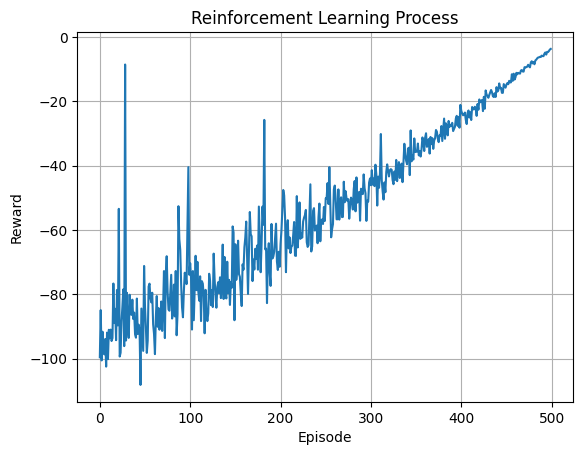

In [162]:
parser = argparse.ArgumentParser(description='PyTorch DDPG solution of Ride_hailing Radius')
parser.add_argument('--gamma', type=float, default=0.9)
parser.add_argument('--lr_actor', type=float, default=0.0008) # default 0.0001
parser.add_argument('--lr_critic', type=float, default=0.001) # default 0.001
parser.add_argument('--tau', type=float, default=0.01) # critic output weights between critic and target networks, default 0.001
parser.add_argument('--batch_size', type=int, default=150)
parser.add_argument('--max_episode', type=int, default=500)
parser.add_argument('--max_explore_eps', type=int, default=500)
parser.add_argument('--hr_time', type=int, default=17)
parser.add_argument('--num_divi', type=int, default=3)
parser.add_argument('--max_steps', type=int, default=200)
args = parser.parse_args(args=[])

ddpg = DDPG(args)
state_rider, policy, R, R_good = ddpg.run_ddpg()
# 匹配率追踪环境

In [154]:
state_rider

array([   3.        ,    2.        ,   23.        ,    1.        ,
          6.16666667,    0.        ,    0.        ,    9.66666667,
          0.        ,  965.        , 1130.        ,  343.        ,
        562.        ,  469.        ,    0.        ,    0.        ,
        370.        ,    0.        ,    0.85      ,    0.        ])

In [142]:
env = RideHailingENV(3)
state = env.reset()
done = False

def get_action(policy, state):
    if not isinstance(state, torch.Tensor):
      state = torch.from_numpy(state.reshape(1, -1)).float()
    action = policy(state)[0]
    print(action)
    return action

step = 0

while not done and step<500:
  action = ddpg.get_action(policy, state)
  action = action.detach().numpy()
  radius = ddpg.get_radius(action)
  state_, reward, done = env.step(action)
  state = state_
  step += 1


{'x': 93.47319572537502, 'y': 24.414434802885985, 'l': 40}


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9 and 20x128)

In [106]:
check_policy, check_critic = ddpg.get_optimal()

#### Developing Notes:

1) the obsevration dimension should be set as fixed, it can be the number of drivers/riders in each cell,
    this will result in a observation space of 48*2 dimension.

2) Dimension number  is important, converange is good when cell number is 4, not good when cell number is 30+, try to reduce cell number.

### Data Norm and Standardarize

In [163]:
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)
loss = np.array(ddpg.debug_info())
loss

array([   0.37961984,   31.826155  ,    0.19302493,    0.05111794,
          0.03561004,    0.08526216,    0.08429363,    0.06173807,
          0.02994506,    0.03192477,    0.03044078, 2998.0076    ,
          0.06040934,    0.04553119,    0.03464632,    0.01631397,
          7.7659082 ,    0.01504578,    3.5665722 ,    0.02380024,
        115.203865  ,    0.01737175,    0.01029997,    0.00929488,
          0.00760523,  765.6242    ,    0.0142738 ,   20.837646  ,
          0.00678017,  427.2946    ,  135.47849   ,    0.01349321,
          0.01017066,    0.01865378,    0.0196146 ,    0.01314118,
         74.57843   ,    0.00734159,   72.39798   ,  111.185524  ,
          0.01171165,   70.10318   ,    0.01709376,    0.01619011,
          0.00898483,    0.00835965,    0.05560062,    0.00714049,
          0.00552982,    0.00863394,  102.9421    ,    0.00905954,
          0.00630187,    0.0044653 ,    7.614458  ,  107.65992   ,
          0.00742975,    0.00443655,    0.00767176,    0.00721

In [164]:
memory = R.get_memory()
memory_list = list(memory)
memory

deque([[array([   0.        ,    0.        ,    9.5       ,    4.        ,
                  5.42857143,    1.        ,    3.        ,   13.5       ,
                  0.        ,    0.        ,    0.        ,  428.        ,
               1236.        ,  301.        , 1197.        , 1043.        ,
                472.        ,    0.        ,    0.85      ,    0.        ]),
        array([-0.9467756 , -0.65236679, -0.70535531, -0.48582825, -0.68328752,
               -0.82569606, -0.75287676, -0.33663563, -0.66438414]),
        -0.17764892837501495,
        array([0.        , 0.        , 0.95      , 0.4       , 0.54285714,
               0.1       , 0.3       , 1.35      , 0.        , 0.        ,
               0.        , 0.14266667, 0.412     , 0.10033333, 0.399     ,
               0.34766667, 0.15733333, 0.        , 0.25      , 0.        ]),
        False],
       [array([0.        , 0.        , 0.95      , 0.4       , 0.54285714,
               0.1       , 0.3       , 1.35      , 

In [165]:
memory_rider = [row[0] for row in memory_list]
mean_r, std_r = np.mean(memory_rider), np.std(memory_rider)
memory_driver = [row[1] for row in memory_list]
mean_d, std_d = np.mean(memory_driver), np.std(memory_driver)
mean_r, std_r, mean_d, std_d

(1.2449242769179893,
 36.642482920332476,
 -0.8312702883559615,
 0.1981965597291656)

In [174]:
class TestEnvironment:
    def __init__(self, args, test_episode_num, time_ids) -> None:
        self.env = RideHailingENV(grid_div=2)
        self.actor = policy
        self.args = args
        self.max_action = self.env.upper_bound
        self.min_action = self.env.lower_bound
        self.axis = (self.min_action + self.max_action) / 2
        self.scale = (self.max_action - self.min_action) / 2
        self.norm_mean_rider, self.norm_std_rider = 46.2662, 31.300931 #0.90319, 2.391894
        self.norm_mean_driver, self.norm_std_driver = 24.9914, 15.329205 #2.538216, 3.704363
        self.score_distance = np.vectorize(lambda distance, max_distance=4000: max(0, min(1, distance / max_distance)))
        self.test_episode = test_episode_num
        self.hr_time = time_ids
        pass
    
    def get_action(self, actor_net, state_rider, state_driver, state_distance):
        if not isinstance(state_rider, torch.Tensor):
            state_rider = torch.from_numpy(state_rider.reshape(1, -1)).float()
        if not isinstance(state_driver, torch.Tensor):
            state_driver = torch.from_numpy(state_driver.reshape(1, -1)).float()
        if not isinstance(state_distance, torch.Tensor):
            state_distance = torch.from_numpy(state_distance.reshape(1, -1)).float()
        action = actor_net(state_rider, state_driver, state_distance)[0]
        return action
  
    def get_radius(self, action): # re-scale action
        radius = action * self.scale + self.axis
        return radius
    
    def norm(self, rider):
        rider = (rider - self.norm_mean_rider) / self.norm_std_rider
        return rider
    
    def run_baseline(self, action_baseline, hr_time):
        base_line, aver_score = [], [0]
        for i in range(self.test_episode):
            state_rider, state_driver, state_distance, done = self.env.reset(time_ini=hr_time)
            episode_reward = 0
            while not done:
                state_rider_, state_driver_, state_distance_, reward, done = self.env.step(action_baseline, hr_time)
                aver_score.append(aver_score[-1] * 0.99 + reward * 0.01)
                episode_reward += reward
            base_line.append(episode_reward)
        # calculate average
        aver_ = sum(base_line) / len(base_line)
        print('Baseline test done!')
        return base_line, aver_

    def run_policy(self, policy, hr_time):
        # run policy in test env for a whole day
        policy_score, aver_score = [], [0]
        for i in range(self.test_episode):
            episode_reward = 0
            reward_set = []
            state_rider, state_driver, state_distance, done = self.env.reset(time_ini=hr_time)
            while not done:
                state_rider, state_driver, state_distance = self.norm(state_rider, state_driver, state_distance)
                action = self.get_action(policy, state_rider, state_driver, state_distance).detach().numpy()
                radius = self.get_radius(action)
                #next_state, reward, done = self.env.step(radius, self.args.hr_time, rend_step=True)
                state_rider_, state_driver_, state_distance_, reward, done = self.env.step(radius, hr_time)
                reward_set.append(reward)
                aver_score.append(aver_score[-1] * 0.99 + reward * 0.01)
                state_rider, state_driver = state_rider_, state_driver_
                episode_reward += reward
            # calculate average
            policy_score.append(episode_reward)
        aver_ = sum(policy_score) / len(policy_score)
        print('Policy test done!')
        return policy_score, aver_

    def run_test(self, bl_1, bl_2, bl_3, bl_4, policy):
        test_set_bl1, avg_set_bl1 = [], []
        test_set_bl2, avg_set_bl2 = [], []
        test_set_bl3, avg_set_bl3 = [], []
        test_set_bl4, avg_set_bl4 = [], []
        test_set_policy, avg_set_policy = [], []

        for i in range(len(self.hr_time)):
            # get result for base line
            test_bl1, avg_bl1 = self.run_baseline(bl_1, self.hr_time[i])
            test_bl2, avg_bl2 = self.run_baseline(bl_2, self.hr_time[i])
            test_bl3, avg_bl3 = self.run_baseline(bl_3, self.hr_time[i])
            test_bl4, avg_bl4 = self.run_baseline(bl_4, self.hr_time[i])
            # get result for trained policy
            test_policy, avg_policy = self.run_policy(policy, self.hr_time[i])

            test_set_bl1.append(test_bl1)
            avg_set_bl1.append(avg_bl1)
            test_set_bl2.append(test_bl2)
            avg_set_bl2.append(avg_bl2)
            test_set_bl3.append(test_bl3)
            avg_set_bl3.append(avg_bl3)
            test_set_bl4.append(test_bl4)
            avg_set_bl4.append(avg_bl4)
            test_set_policy.append(test_policy)
            avg_set_policy.append(avg_policy)

        time = ['0:00 AM', '6:00 AM', '12:00 AM', '18:00 PM', '24:00 PM']
        avg_set_bl1.insert(0, avg_set_bl1[-1])
        avg_set_bl2.insert(0, avg_set_bl2[-1])
        avg_set_bl3.insert(0, avg_set_bl3[-1])
        avg_set_bl4.insert(0, avg_set_bl4[-1])
        avg_set_policy.insert(0, avg_set_policy[-1])

        plt.plot(time, avg_set_bl1, marker='o', label='FR 500m', color='b')
        plt.plot(time, avg_set_bl2, marker='o', label='FR 1000m', color='g')
        plt.plot(time, avg_set_bl3, marker='o', label='FR 1500m', color='m')
        plt.plot(time, avg_set_bl4, marker='o', label='FR 2000m', color='c')
        plt.plot(time, avg_set_policy, marker='o', label='Optimal Policy', color='r')

        # test figure
        plt.xlabel('Time of the day')
        plt.ylabel('Average Reward')
        plt.title('Test Environment Optimal Policy')
        plt.grid()
        plt.legend(['FR 500m', 'FR 1000m', 'FR 1500m', 'FR 2000m', 'Optimal Policy'])
        plt.show()

    def run_test_local(self, bl_1, bl_2, bl_3, bl_4, policy, test_time):
        # run policy in test env in one time of the day
        test_set_bl1, avg_set_bl1 = [], []
        test_set_bl2, avg_set_bl2 = [], []
        test_set_bl3, avg_set_bl3 = [], []
        test_set_bl4, avg_set_bl4 = [], []
        test_set_policy, avg_set_policy = [], []

        # get result for base line
        test_bl1, avg_bl1 = self.run_baseline(bl_1, test_time)
        test_bl2, avg_bl2 = self.run_baseline(bl_2, test_time)
        test_bl3, avg_bl3 = self.run_baseline(bl_3, test_time)
        test_bl4, avg_bl4 = self.run_baseline(bl_4, test_time)
        # get result for trained policy
        test_policy, avg_policy = self.run_policy(policy, test_time)

        plt.plot(test_bl1, label='FR 500m', color='b')
        plt.plot(test_bl2, label='FR 1000m', color='g')
        plt.plot(test_bl3, label='FR 1500m', color='m')
        plt.plot(test_bl4, label='FR 2000m', color='c')
        plt.plot(test_policy, label='Optimal Policy', color='r')

        # test figure
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Test Environment Optimal Policy - One time')
        plt.grid()
        plt.legend(['FR 500m', 'FR 1000m', 'FR 1500m', 'FR 2000m', 'Optimal Policy'])
        plt.show()


In [175]:
# Actions for baseline
action_fr_1 = np.ones(4)*500
action_fr_2 = np.ones(4)*1000
action_fr_3 = np.ones(4)*1500
action_fr_4 = np.ones(4)*2000

test = TestEnvironment(args, 30, [10, 16, 21])

Baseline test done!
Baseline test done!
Baseline test done!
Baseline test done!
Policy test done!


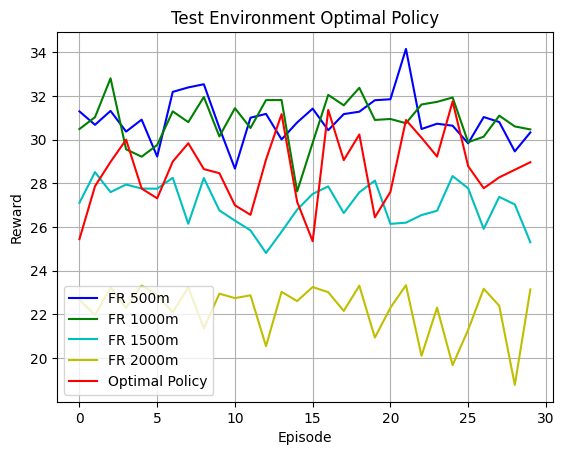

In [20]:
test.run_test(action_fr_1, action_fr_2, action_fr_3, action_fr_4, policy)

In [176]:
np.set_printoptions(suppress=True)
state_rider_ = torch.from_numpy(state_rider.reshape(1, -1)).float()
state_rider_ = test.norm(state_rider_)
action = policy(state_rider_)[0]
action = ddpg.get_radius(action)
action.detach().numpy()

array([  50., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.],
      dtype=float32)

In [179]:
env_my = RideHailingENV(grid_div=3)

In [180]:
rider = env_my.reset()
rider = torch.from_numpy(rider.reshape(1, -1)).float()
rider = test.norm(rider)
action = policy(rider)
action = ddpg.get_radius(action)
action.detach().numpy()

array([[50., 50., 50., 50., 50., 50., 50., 50., 50.]], dtype=float32)

In [ ]:
loss = ddpg.debug_info()
print(loss)

In [ ]:
ddpg_agent = DDPG(args)
actor_my = Actor(14, 7)
action = ddpg_agent.get_action(actor_my, state_my).detach().numpy()
action = ddpg_agent.get_radius(action)
print(action)

In [ ]:
state, reward, done = env_my.step(action, hr_time=6)
print(state, reward, done)

In [ ]:
noise = OUNoise(env_my.action_space.shape[0])
k_noise = noise.sample()
action = 0.8*action + 0.2*k_noise
action = np.clip(action, -1, 1)
action

In [ ]:
noise = OUNoise(4)
radius = np.full(4, 0)
exp = 0.1*noise.sample() + 0.9*radius
exp = np.clip(exp, -1, 1)
print(ddpg.get_radius(exp))
print(ddpg.get_radius(radius))

In [ ]:
list_1 = [1, 2, 3]
list_2 = [4, 5, 6]
list_3 = list_1 + list_2
list_3

PPO algorithm

In [ ]:
actor = Actor(3, 3)

In [ ]:
out = actor(torch.Tensor([[1, 2, 3], [7, 7, 4]]), torch.Tensor([[2, 3, 6], [2, 5, 3]]))
out[0]